In [1]:
import numpy as np
import optuna
from matplotlib import pyplot as plt

from utils.core import calculate_ema, load_file
from utils.hyperparameter_optimization import objective_sgd, objective_lsa
from utils.normalization import normalize_minmax
from utils.error_function import mean_square_error, mean_square_error_gradient, symmetric_mean_absolute_percentage_error, symmetric_mean_absolute_percentage_error_gradient, normalized_root_mean_square_error
from utils.algorithms import apply_error_function, least_squares_approximation, stochastic_gradient_descent

In [2]:
objects_train, objects_test = load_file("data/LR/1.txt")
objects_train = normalize_minmax(objects_train)
objects_test = normalize_minmax(objects_test)

# Буду использовать стохастический градиентный спуск с гребневой регуляризацией:
![jupyter](./resources/pic1.png)
![jupyter](./resources/pic2.png)


In [3]:
X_train = []
Y_train = []
for i in range(len(objects_train)):
    X_train.append(objects_train[i].features)
    Y_train.append(objects_train[i].target)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = []
Y_test = []
for i in range(len(objects_test)):
    X_test.append(objects_test[i].features)
    Y_test.append(objects_test[i].target)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

def add(X, feature_value=1):
    X_new = np.zeros((len(X), len(X[0]) + 1))
    for i in range(len(X)):
        for j in range(len(X[0])):
            X_new[i][j] = X[i][j]
        X_new[i][len(X[0])] = feature_value
    return X_new

X_train = add(X_train)
X_test = add(X_test)

In [4]:
%%time

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial : objective_lsa(trial, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, function=symmetric_mean_absolute_percentage_error), n_trials=1000)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-03-21 23:23:05,231] A new study created in memory with name: no-name-b0fc1dde-d507-40da-bafa-384b91bea591
[I 2022-03-21 23:23:05,267] Trial 0 finished with value: 5.901709804892738 and parameters: {'tau': 0.06659532801874467}. Best is trial 0 with value: 5.901709804892738.
[I 2022-03-21 23:23:05,286] Trial 1 finished with value: 5.874201237402411 and parameters: {'tau': 0.5582597976980516}. Best is trial 1 with value: 5.874201237402411.
[I 2022-03-21 23:23:05,313] Trial 2 finished with value: 5.874148069888833 and parameters: {'tau': 0.5737800876483883}. Best is trial 2 with value: 5.874148069888833.
[I 2022-03-21 23:23:05,336] Trial 3 finished with value: 5.875698582891788 and parameters: {'tau': 0.3647451225188176}. Best is trial 2 with value: 5.874148069888833.
[I 2022-03-21 23:23:05,360] Trial 4 finished with value: 5.873915673465945 and parameters: {'tau': 0.6860928386740833}. Best is trial 4 with value: 5.873915673465945.
[I 2022-03-21 23:23:05,392] Trial 5 finished with 

Number of finished trials: 1000
Best trial: {'tau': 0.7771476195441551}
Best score: 5.873868787613231
CPU times: user 2min 17s, sys: 34.2 s, total: 2min 52s
Wall time: 22.1 s


In [5]:
trials_lsa = sorted(study.trials_dataframe()['params_tau'].tolist())
predictions_mse = []
predictions_smape = []
for tau in trials_lsa:
    lsa = least_squares_approximation(X_train, Y_train, tau)
    predictions_mse.append(apply_error_function(X_test, Y_test, lsa, mean_square_error))
    predictions_smape.append(apply_error_function(X_test, Y_test, lsa, symmetric_mean_absolute_percentage_error))

[Text(0.5, 0, 'tau'), Text(0, 0.5, 'error')]

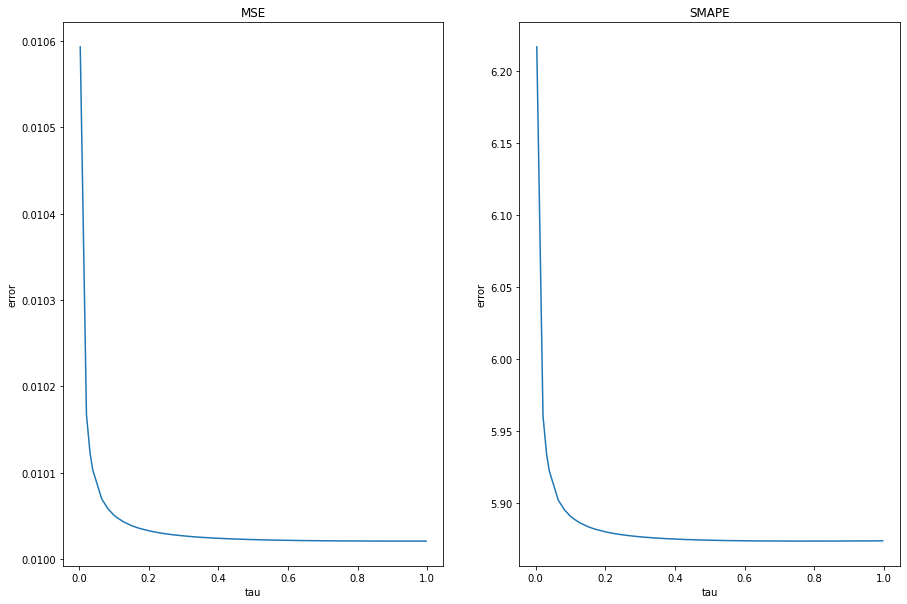

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(trials_lsa, predictions_mse)
ax2.plot(trials_lsa, predictions_smape)
ax1.set_title('MSE')
ax2.set_title('SMAPE')
ax1.set(xlabel='tau', ylabel='error')
ax2.set(xlabel='tau', ylabel='error')

In [7]:
lsa = least_squares_approximation(X_train, Y_train, study.best_trial.params['tau'])

In [8]:
%%time

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial : objective_sgd(trial, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, function=mean_square_error, gradient=mean_square_error_gradient), n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-03-21 23:23:37,136] A new study created in memory with name: no-name-db86b304-396c-4130-9fbd-2058816948d3
[I 2022-03-21 23:23:38,047] Trial 0 finished with value: 20.198883805711255 and parameters: {'tau': 14.356362457145641, 'step': 0.07610619458294278, 'alpha': 0.6483255617522965}. Best is trial 0 with value: 20.198883805711255.
[I 2022-03-21 23:23:38,939] Trial 1 finished with value: 10.220003350687351 and parameters: {'tau': 1.6727780898557363, 'step': 0.03769022951010269, 'alpha': 0.8672396652321835}. Best is trial 1 with value: 10.220003350687351.
[I 2022-03-21 23:23:39,783] Trial 2 finished with value: 67.55387562373386 and parameters: {'tau': 7.547839900988374, 'step': 0.08644986147316365, 'alpha': 0.4728252825906982}. Best is trial 1 with value: 10.220003350687351.
[I 2022-03-21 23:23:40,648] Trial 3 finished with value: 71.68611619763983 and parameters: {'tau': 2.4940970528198445, 'step': 0.07161396608063668, 'alpha': 0.4706076834230293}. Best is trial 1 with value: 1

Number of finished trials: 100
Best trial: {'tau': 1.1748004312453766, 'step': 0.025816991943974035, 'alpha': 0.8217836373987348}
Best score: 8.516175891759115
CPU times: user 1min 12s, sys: 1.53 s, total: 1min 13s
Wall time: 1min 12s


In [9]:
tau_sgd_mse = study.best_trial.params['tau']
step_sgd_mse = study.best_trial.params['step']
alpha_sgd_mse = study.best_trial.params['alpha']

sgd_mse, log_mse = stochastic_gradient_descent(X_train, Y_train, tau_sgd_mse, mean_square_error, mean_square_error_gradient, alpha_sgd_mse, step_sgd_mse, 2000)

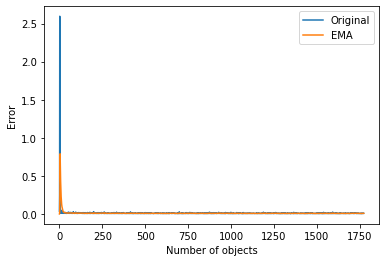

In [10]:
ema_X = list(range(len(log_mse) + 1))
ema_Y = calculate_ema(log_mse, 0.2)

original_X = list(range(len(log_mse)))
original_Y = log_mse

plt.xlabel('Number of objects')
plt.ylabel('Error')
plt.plot(original_X, original_Y, label='Original')
plt.plot(ema_X, ema_Y, label='EMA')
plt.legend()
plt.show()

In [11]:
%%time

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial : objective_sgd(trial, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, function=symmetric_mean_absolute_percentage_error, gradient=symmetric_mean_absolute_percentage_error_gradient), n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2022-03-21 23:24:50,451] A new study created in memory with name: no-name-55c40d4e-144a-41ae-b4a5-94bcf3e730f0
[I 2022-03-21 23:24:52,130] Trial 0 finished with value: 8.760985483184594 and parameters: {'tau': 18.772443883995063, 'step': 0.042630036206558294, 'alpha': 0.415769654900648}. Best is trial 0 with value: 8.760985483184594.
[I 2022-03-21 23:24:53,686] Trial 1 finished with value: 21.342595524681208 and parameters: {'tau': 8.62146324012277, 'step': 0.04868796514120261, 'alpha': 0.5559014930516084}. Best is trial 0 with value: 8.760985483184594.
[I 2022-03-21 23:24:55,258] Trial 2 finished with value: 7.601260479307752 and parameters: {'tau': 14.42416845201618, 'step': 0.0796090142219959, 'alpha': 0.20814596834288893}. Best is trial 2 with value: 7.601260479307752.
[I 2022-03-21 23:24:56,834] Trial 3 finished with value: 7.332414358298098 and parameters: {'tau': 16.00036369270633, 'step': 0.05635987859689446, 'alpha': 0.4105924724725639}. Best is trial 3 with value: 7.332414

Number of finished trials: 100
Best trial: {'tau': 6.787139415032685, 'step': 0.09618186264607105, 'alpha': 0.3205503685183505}
Best score: 5.640674932506126
CPU times: user 2min 49s, sys: 1.69 s, total: 2min 51s
Wall time: 2min 50s


In [12]:
tau_sgd_smape = study.best_trial.params['tau']
step_sgd_smape = study.best_trial.params['step']
alpha_sgd_smape = study.best_trial.params['alpha']

sgd_smape, log_smape = stochastic_gradient_descent(X_train, Y_train, tau_sgd_smape, symmetric_mean_absolute_percentage_error, symmetric_mean_absolute_percentage_error_gradient, alpha_sgd_smape, step_sgd_smape, 2000)

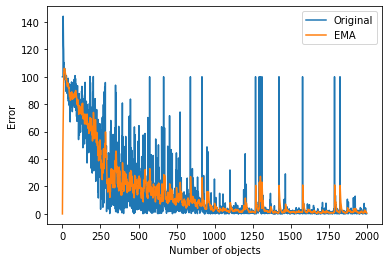

In [13]:
ema_X = list(range(len(log_smape) + 1))
ema_Y = calculate_ema(log_smape, 0.2)

original_X = list(range(len(log_smape)))
original_Y = log_smape

plt.xlabel('Number of objects')
plt.ylabel('Error')
plt.plot(original_X, original_Y, label='Original')
plt.plot(ema_X, ema_Y, label='EMA')
plt.legend()
plt.show()

In [14]:
lsa_smape = apply_error_function(X_test, Y_test, lsa, symmetric_mean_absolute_percentage_error)
lsa_nrmse = apply_error_function(X_test, Y_test, lsa, normalized_root_mean_square_error)

sgd_mse_smape = apply_error_function(X_test, Y_test, sgd_mse, symmetric_mean_absolute_percentage_error)
sgd_mse_nrmse = apply_error_function(X_test, Y_test, sgd_mse, normalized_root_mean_square_error)

sgd_smape_smape = apply_error_function(X_test, Y_test, sgd_smape, symmetric_mean_absolute_percentage_error)
sgd_smape_nrmse = apply_error_function(X_test, Y_test, sgd_smape, normalized_root_mean_square_error)

In [15]:
print("lsa_smape = ", lsa_smape)
print("lsa_nrmse = ", lsa_nrmse)
print("sgd_mse_smape = ", sgd_mse_smape)
print("sgd_mse_nrmse = ", sgd_mse_nrmse)
print("sgd_smape_smape = ", sgd_smape_smape)
print("sgd_smape_nrmse = ", sgd_smape_nrmse)

lsa_smape =  5.873868787613231
lsa_nrmse =  0.1001066555356057
sgd_mse_smape =  8.516175891759115
sgd_mse_nrmse =  0.12431643421726028
sgd_smape_smape =  5.640674932506126
sgd_smape_nrmse =  0.09774526533713757
